In [1]:
import random, os, tqdm, time, json
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../../")

random.seed(618)
np.random.seed(907)

new_base_path = os.path.join(
    "/Users/minkexiu/Downloads/",
    "/".join(
        os.getcwd().split("/")[-1*(len(sys.path[-1].split("/")) - 1):]
    ),
)
print("storage dir:", new_base_path)
print("code dir:", os.getcwd())

## 创建文件夹。
if not os.path.exists(new_base_path):
    os.makedirs(
        new_base_path
    )
if not os.path.exists(os.path.join(new_base_path, "preprocessedData")):
    os.makedirs(
        os.path.join(new_base_path, "preprocessedData")
    )
if not os.path.exists(os.path.join(new_base_path, "originalData")):
    os.makedirs(
        os.path.join(new_base_path, "originalData")
    )
if not os.path.exists(os.path.join(new_base_path, "trained_models")):
    os.makedirs(
        os.path.join(new_base_path, "trained_models")
    )

def create_originalData_path(filename_or_path):
    return os.path.join(new_base_path, "originalData", filename_or_path)
def create_preprocessedData_path(filename_or_path):
    return os.path.join(new_base_path, "preprocessedData", filename_or_path)
def create_trained_models_path(filename_or_path):
    return os.path.join(new_base_path, "trained_models", filename_or_path)

def millisec2datetime(timestamp):
    time_local = time.localtime(timestamp/1000)
    return time.strftime("%Y-%m-%d %H:%M:%S", time_local)
    
def run_finish():
    # 假设你的字体文件是 'myfont.ttf' 并且位于当前目录下  
    font = FontProperties(fname="/Users/minkexiu/Documents/GitHub/ML_Tryout/SimHei.ttf", size=24)  
    # 创建一个空白的图形  
    fig, ax = plt.subplots()  
    ax.imshow(
        plt.imread("/Users/minkexiu/Downloads/wallhaven-dgxpyg.jpg")
    )
    # 在图形中添加文字  
    ax.text(
        ax.get_xlim()[1] * 0.5, 
        ax.get_ylim()[0] * 0.5, 
        f"程序于这个点跑完：\n{millisec2datetime(time.time()*1000)}", fontproperties=font, ha="center", va="center", color="red"
    )  
    # 设置图形的布局  
    # ax.set_xlim(0, 1)  
    # ax.set_ylim(0, 1)  
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.patch.set_color("blue")
    # 显示图形  
    plt.show()
        
tqdm.tqdm.pandas() ## 引入这个，就可以在apply的时候用progress_apply了。

import IPython
def kill_current_kernel():
    '''杀死当前的kernel释放内存空间。'''
    IPython.Application.instance().kernel.do_shutdown(True) 
    
def simply_show_data(df1):
    print(df1.shape)
    display(df1.head())
    
def wait_flag(saved_flag_path, time_interval_sec=10):
    print("waiting for", saved_flag_path)
    time_count = 0
    while True:
        if os.path.exists(saved_flag_path):
            break
        time.sleep(time_interval_sec)
        time_count+=time_interval_sec
        print(time_count, end=" ")
    print("finish!!")

storage dir: /Users/minkexiu/Downloads/GitHub/ML_Tryout/LLM/大规模语言模型：从理论到实践
code dir: /Users/minkexiu/Documents/GitHub/ML_Tryout/LLM/大规模语言模型：从理论到实践


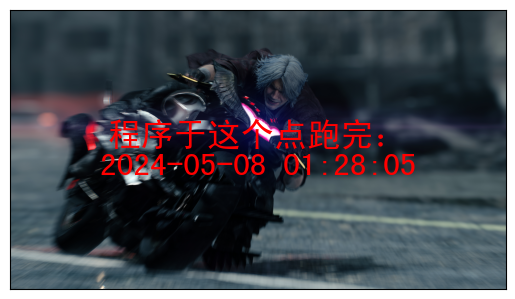

In [2]:
run_finish()

# 玩玩Einops

https://medium.com/@kyeg/einops-in-30-seconds-377a5f4d641a

In [3]:
import torch
from einops import rearrange

# Create a 4D tensor of shape (batch, channels, height, width)
tensor = torch.rand(10, 3, 32, 32)  # Example: a batch of 10 RGB images 32x32
# Rearrange to (batch, height, width, channels) for image processing libraries that expect this format
rearranged = rearrange(tensor, 'b c h w -> b h w c')

In [5]:
rearranged.shape

torch.Size([10, 32, 32, 3])

In [7]:
rearrange(tensor, 'a b c d -> d c b a').shape
## xmk：看起来ho，四个字母是什么其实无所谓。
## 重点是字母相对位置的变化。

torch.Size([32, 32, 3, 10])

In [8]:
from einops import reduce

# Reduce the tensor's channel dimension by taking the mean, resulting in a grayscale image
grayscale = reduce(
    tensor, 
    'b c h w -> b h w', 
    'mean'
)
## 这个就是降维方式了。
## 这里可以将mean改成其他聚合方式。大意就是，去掉c这个维度，然后hw的值就是原来c上各个值的均值了。

In [23]:
from einops import repeat

# Repeat each image in the batch 4 times along a new dimension
repeated = repeat(tensor, 'b c h w -> (repeat b) c h w', repeat=4)

In [25]:
flattened = rearrange(tensor, 'b c h w -> b (c h w)')
tensor.shape, flattened.shape

(torch.Size([10, 3, 32, 32]), torch.Size([10, 3072]))

In [31]:
xxx = rearrange(
    tensor, 
    'b (c rgb) h w -> rgb b c h w', ## 看起来括号内的就是一个维度。这里是把原来的3这个维度，拆成c * rgb维，然后rgb被定为3，这么一来c就是1了。
    rgb=3
)

In [29]:
tensor.shape

torch.Size([10, 3, 32, 32])

In [33]:
xxx.shape

torch.Size([3, 10, 1, 32, 32])

In [30]:
red.shape

torch.Size([10, 1, 32, 32])

# 解读


In [ ]:
import math

import warnings
import torch
import torch.nn as nn
from einops import rearrange

from typing import Optional


def scaled_multihead_dot_product_attention(
        query,

    
        key,
        value,
        n_heads,
        past_key_value=None,
        softmax_scale=None,
        attn_bias=None,
        key_padding_mask=None,
        is_causal=False,
        dropout_p=0.0,
        training=False,
        needs_weights=False,
        multiquery=False,
    ):
    q = rearrange(query, 'b s (h d) -> b h s d', h=n_heads)         # (1, 512, 768) -> (1, 8, 512, 96)
    kv_n_heads = 1 if multiquery else n_heads
    k = rearrange(key, 'b s (h d) -> b h d s', h=kv_n_heads)        # (1, 512, 768) -> (1, 8, 96, 512) if not multiquery 
                                                                    # (1, 512, 96) -> (1, 1, 96, 512)  if multiquery
    v = rearrange(value, 'b s (h d) -> b h s d', h=kv_n_heads)      # (1, 512, 768) -> (1, 8, 512, 96) if not multiquery 
                                                                    # (1, 512, 96) -> (1, 1, 512, 96)  if multiquery
    
    attn_weight = q.matmul(k) * softmax_scale                       # (1, 8, 512, 512)
    attn_weight = torch.softmax(attn_weight, dim=-1)                # (1, 8, 512, 512)

    out = attn_weight.matmul(v)                                     # (1, 8, 512, 512) * (1, 1, 512, 96) = (1, 8, 512, 96)
    out = rearrange(out, 'b h s d -> b s (h d)')                    # (1, 512, 768)

    return out, attn_weight, past_key_value


class MultiheadAttention(nn.Module):
    """Multi-head self attention.

    Using torch or triton attention implemetation enables user to also use
    additive bias.
    """

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        attn_impl: str = 'triton',
        clip_qkv: Optional[float] = None,
        qk_ln: bool = False,
        softmax_scale: Optional[float] = None,
        attn_pdrop: float = 0.0,
        low_precision_layernorm: bool = False,
        verbose: int = 0,
        device: Optional[str] = None,
    ):
        super().__init__()

        self.attn_impl = attn_impl
        self.clip_qkv = clip_qkv
        self.qk_ln = qk_ln

        self.d_model = d_model
        self.n_heads = n_heads
        self.softmax_scale = softmax_scale
        if self.softmax_scale is None:
            self.softmax_scale = 1 / math.sqrt(self.d_model / self.n_heads)
        self.attn_dropout_p = attn_pdrop

        self.Wqkv = nn.Linear(self.d_model, 3 * self.d_model, device=device)

        fuse_splits = (d_model, 2 * d_model)
        self.Wqkv._fused = (0, fuse_splits)  # type: ignore

        self.attn_fn = scaled_multihead_dot_product_attention
        self.out_proj = nn.Linear(self.d_model, self.d_model, device=device)
        self.out_proj._is_residual = True  # type: ignore

    def forward(
        self,
        x,
        past_key_value=None,
        attn_bias=None,
        attention_mask=None,
        is_causal=True,
        needs_weights=False,
    ):
        qkv = self.Wqkv(x)                                              # (1, 512, 2304)

        if self.clip_qkv:
            qkv.clamp_(min=-self.clip_qkv, max=self.clip_qkv)

        query, key, value = qkv.chunk(3, dim=2)                         # both q, k, v: (1, 512, 768)

        key_padding_mask = attention_mask

        context, attn_weights, past_key_value = self.attn_fn(
            query,
            key,
            value,
            self.n_heads,
            past_key_value=past_key_value,
            softmax_scale=self.softmax_scale,
            attn_bias=attn_bias,
            key_padding_mask=key_padding_mask,
            is_causal=is_causal,
            dropout_p=self.attn_dropout_p,
            training=self.training,
            needs_weights=needs_weights,
        )

        return self.out_proj(context), attn_weights, past_key_value


class MultiQueryAttention(nn.Module):
    """Multi-Query self attention.

    Using torch or triton attention implemetation enables user to also use
    additive bias.
    """

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        attn_impl: str = 'triton',
        clip_qkv: Optional[float] = None,
        qk_ln: bool = False,
        softmax_scale: Optional[float] = None,
        attn_pdrop: float = 0.0,
        low_precision_layernorm: bool = False,
        verbose: int = 0,
        device: Optional[str] = None,
    ):
        super().__init__()

        self.attn_impl = attn_impl
        self.clip_qkv = clip_qkv
        self.qk_ln = qk_ln

        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.softmax_scale = softmax_scale
        if self.softmax_scale is None:
            self.softmax_scale = 1 / math.sqrt(self.head_dim)
        self.attn_dropout_p = attn_pdrop

        self.Wqkv = nn.Linear(
            d_model,
            d_model + 2 * self.head_dim,
            device=device,
        )

        fuse_splits = (d_model, d_model + self.head_dim)
        self.Wqkv._fused = (0, fuse_splits)  # type: ignore

        self.attn_fn = scaled_multihead_dot_product_attention
        self.out_proj = nn.Linear(self.d_model, self.d_model, device=device)
        self.out_proj._is_residual = True  # type: ignore

    def forward(
        self,
        x,
        past_key_value=None,
        attn_bias=None,
        attention_mask=None,
        is_causal=True,
        needs_weights=False,
    ):
        qkv = self.Wqkv(x)                                      # (1, 512, 960)

        if self.clip_qkv:
            qkv.clamp_(min=-self.clip_qkv, max=self.clip_qkv)

        query, key, value = qkv.split(                                  # query -> (1, 512, 768)
            [self.d_model, self.head_dim, self.head_dim],               # key   -> (1, 512, 96)
            dim=2                                                       # value -> (1, 512, 96)
        )

        key_padding_mask = attention_mask

        if self.qk_ln:
            # Applying layernorm to qk
            dtype = query.dtype
            query = self.q_ln(query).to(dtype)
            key = self.k_ln(key).to(dtype)

        context, attn_weights, past_key_value = self.attn_fn(
            query,
            key,
            value,
            self.n_heads,
            past_key_value=past_key_value,
            softmax_scale=self.softmax_scale,
            attn_bias=attn_bias,
            key_padding_mask=key_padding_mask,
            is_causal=is_causal,
            dropout_p=self.attn_dropout_p,
            training=self.training,
            needs_weights=needs_weights,
            multiquery=True,
        )

        return self.out_proj(context), attn_weights, past_key_value
    

if __name__ == '__main__':
    # attn = MultiQueryAttention(
    #     768,
    #     8,
    #     'torch'
    # )

    attn = MultiheadAttention(
        768,
        8,
        'torch'
    )

    attn(
        torch.ones(size=(1, 512, 768))
    )